# データの準備

In [41]:
import pandas as pd

# データの読み込み
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [42]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

In [43]:
# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]
# index を振り直す
df_wrime_target = df_wrime_target.reset_index(drop=True)
# df_wrime_target.info()

In [44]:
# リスト化
sentences = df_wrime_target['Sentence'].tolist()

# 「\n」を「」に置換する
sentences = [sentence.replace('\\n', ' ') for sentence in sentences]
# 「x000D」を「」に置換する
sentences = [sentence.replace('x000D', ' ') for sentence in sentences]

In [45]:
import os
out_dir_path = "embeddings"
if not os.path.isdir(out_dir_path):
    os.makedirs(out_dir_path)
path_to_embeddings = os.path.join(out_dir_path, 'pretrained_embeddings.tsv')

# Pre-trained model

In [46]:
def make_embeddings(sentences):
    import torch
    from transformers import AutoTokenizer, AutoModelForSequenceClassification

    # Load pretrained model/tokenizer. 
    checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking' # 'cl-tohoku/bert-base-japanese-v2'
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, output_hidden_states=True) # output_hidden_states=True allows us to access hidden states. 

    from transformers import TRANSFORMERS_CACHE
    print(TRANSFORMERS_CACHE)




    from torch.utils.data import DataLoader

    # 入力文章をトークン化する関数
    def tokenize(text):
        return tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt")

    # データローダーを作成する
    batch_size = 64
    dataloader = DataLoader(sentences, batch_size=batch_size, collate_fn=tokenize)

    # モデルをGPUに移動する
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # バッチ処理で分散表現を取得する
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            # バッチをGPUに移動する
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            hidden_states = outputs.hidden_states
            embeddings.append(hidden_states[-1][:, 0]) # 最後の層のCLSトークンのみ取得する

    embeddings = torch.cat(embeddings)
    # in 30 sec.

    # pandasのDataFrameに変換する
    df_embeddings = pd.DataFrame(embeddings.tolist())
    df_embeddings.info()
    # Save.
    df_embeddings.to_csv(path_to_embeddings, sep='\t', index=False, header=False)




# Prepare embeddings of tweets based on emotional intensities. 

In [47]:
if os.path.isfile(path_to_embeddings):
    df_embeddings = pd.read_table(path_to_embeddings, header=None)
else:
    df_embeddings = make_embeddings(sentences)

### Similarity between sentences

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

# target_indexの文章と類似度の高い文章を表示する
target_index = 1

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'文　章：{row["Sentence"]}')
    print(f'類似度：{row["similarity"]}')
    print('---')

index: 1
文　章：今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も悪くない｡
類似度：1.0000000000000004
---
index: 7215
文　章：そろそろ家の近く散策してみようか、と思った日に雨。 家でおとなしくしていよう。
類似度：0.9288621701404358
---
index: 7761
文　章：こんな時間に睡魔が…。今寝てしまったら、夜眠れなくなる…。明日は髪狩様のところに10時に行かねばならぬというのに。眠い。
類似度：0.9281981084541548
---
index: 14186
文　章：昨日から声が掠れて、きょうは少し咳が出る。夏かぜだと思いたい……。24時間冷房いれっぱなしなのできっとそうよ（誰に言う）。
類似度：0.9266035761895483
---
index: 13767
文　章：台風（；＿；）（；＿；）（；＿；）
類似度：0.4080009061452131
---
index: 6302
文　章：QUEEN+ADAM LAMBERTのチケット取れた！
類似度：0.48197624636696346
---
index: 4770
文　章：餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子餃子
類似度：0.48752712582604024
---


---

# K-means clustering by embeddings. 

In [49]:
from sklearn.cluster import KMeans

# k: Number of clusters (optional)
k = 6

# Run k-means
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)

# Cluster ID (0-based) for each tweet. 
clusters = kmeansModel.labels_
# Cluster ID is 1-based. 
clusters = clusters + 1
print(kmeansModel.labels_)
print(len(kmeansModel.labels_))

/home/om/.miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[5 5 5 ... 0 5 2]
18237


In [50]:
# ここは途中．自動でclusterの対応関係を同定したい．
a = 4 
b = 6

clusters[clusters == a] = -1
clusters[clusters == b] = a
clusters[clusters == -1] = b

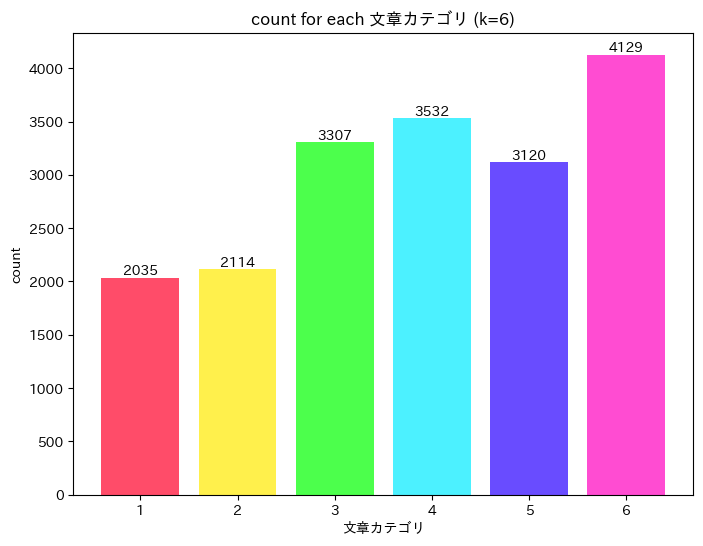

In [51]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
import numpy as np

# 日本語フォントの設定
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# 各クラスの度数を計算
unique_clusters, counts = np.unique(clusters, return_counts=True)

# カラーマップを取得
cmap_name = 'gist_rainbow'
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, len(unique_clusters)))

# 可視化
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_clusters, counts, color=colors, alpha=0.7)
plt.xlabel('文章カテゴリ')
plt.ylabel('count')
plt.title(f'count for each 文章カテゴリ (k={k})')
plt.xticks(unique_clusters)

# テキストを表示
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

## Load the intensity-based clusters

In [52]:
# clusters/emotion_6clusters.tsvを読み込み
df_clusters = pd.read_csv('clusters/emotion_6clusters.tsv', sep='\t', header=None)
# 変換
emotion_clusters = df_clusters[0].tolist()
emotion_clusters = [int(x) for x in emotion_clusters]
df_intensity_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])
df_intensity_clusters.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


## Comparison of the embedding-based clusters with the intensity-based clusters. 

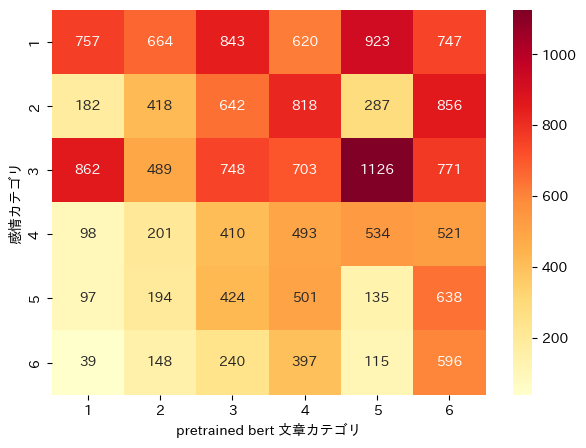

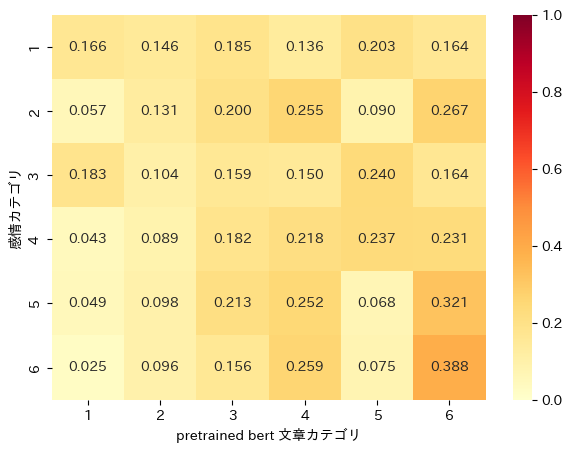

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

df_clusters = pd.DataFrame(clusters, columns=['clusters'])
# pretrained bertのクラスタリングとemotionのクラスタリングの比較
cm = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('pretrained bert 文章カテゴリ')
plt.ylabel('感情カテゴリ')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('pretrained bert 文章カテゴリ')
plt.ylabel('感情カテゴリ')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()




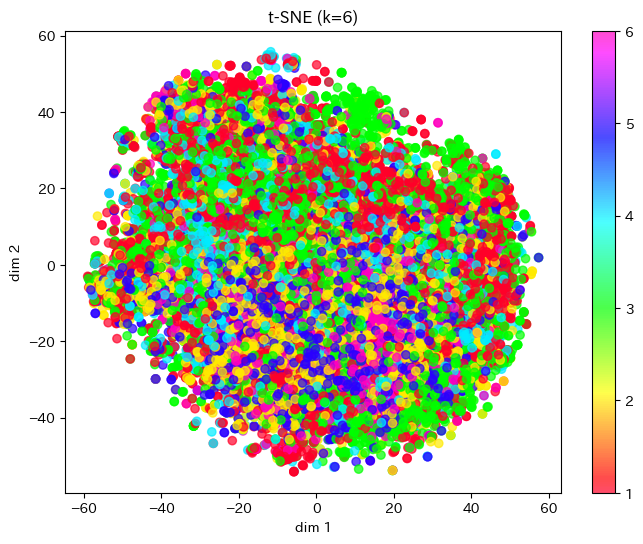

In [54]:
from sklearn.manifold import TSNE

# t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
df_wrime_features_tsne = tsne.fit_transform(df_embeddings)

# Visualize.
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

## クラスター数の決定

In [55]:
k_max=41

### エルボー法による最適クラスター数の調査
エルボー法では、SSE値(残差平方和)が急激に減少している部分において、SSE値が最も小さい点が最適なクラスター数であると判断する

In [56]:
'''
from sklearn.cluster import KMeans

# Survey of optimal number of clusters by Elbow Method
SSE = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    SSE.append(kmeans_model.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), SSE, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('SSE')
plt.title('Survey of optimal number of clusters by Elbow Method')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\n\n# Survey of optimal number of clusters by Elbow Method\nSSE = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    SSE.append(kmeans_model.inertia_)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), SSE, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('SSE')\nplt.title('Survey of optimal number of clusters by Elbow Method')\nplt.grid(True)\nplt.show()\n"

### シルエット係数による最適クラスター数の調査

In [57]:
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Survey of optimal number of clusters by Silhouette Coefficient
silhouette_coefficients = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    silhouette_coefficient = silhouette_score(df_embeddings, kmeans_model.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Silhouette Coefficient')
plt.title('Survey of optimal number of clusters by Silhouette Coefficient')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\nfrom sklearn.metrics import silhouette_score\n\n# Survey of optimal number of clusters by Silhouette Coefficient\nsilhouette_coefficients = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    silhouette_coefficient = silhouette_score(df_embeddings, kmeans_model.labels_) # シルエット係数の平均値\n    silhouette_coefficients.append(silhouette_coefficient)\n\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('Silhouette Coefficient')\nplt.title('Survey of optimal number of clusters by Silhouette Coefficient')\nplt.grid(True)\nplt.show()\n"

### シルエット図

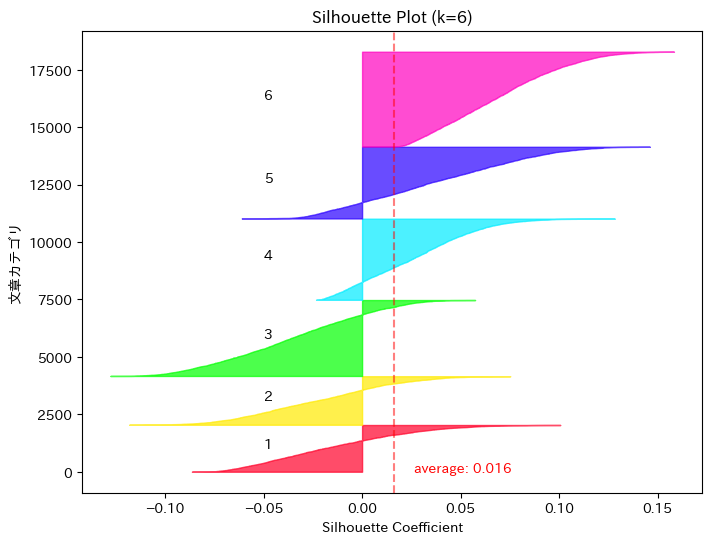

In [58]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i+1))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"average: {silhouette_avg:.3f}", color="red")

plt.xlabel('Silhouette Coefficient')
plt.ylabel('文章カテゴリ')
plt.title(f'Silhouette Plot (k={k})')
plt.show()

In [59]:
# 各文章カテゴリのシルエット係数が最も高い文章を表示
for i, cluster in enumerate(unique_clusters):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が最も高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-1]:.3f}')
    print('---')

文章カテゴリ: 1
シルエット係数が最も高い文章: キャスに来てくれた方、ありがとうございました。とても楽しかったです。またよろしくお願いします。
シルエット係数: 0.101
---
文章カテゴリ: 2
シルエット係数が最も高い文章: 逃げ恥ロス(´･_･`)
シルエット係数: 0.075
---
文章カテゴリ: 3
シルエット係数が最も高い文章: 4時間半渋滞からの30分ばか運転からの休憩で完全に足が震えている
シルエット係数: 0.057
---
文章カテゴリ: 4
シルエット係数が最も高い文章: 明日が来なければいいのに…。やだなー。
シルエット係数: 0.128
---
文章カテゴリ: 5
シルエット係数が最も高い文章: 鍵山くん最終グループ！
シルエット係数: 0.146
---
文章カテゴリ: 6
シルエット係数が最も高い文章: 勧誘にも限度がある。\n飛行機やダイビングはちょっと…。そういうタイプじゃない。オシャレ着は苦手と色々言って断ってるのに「みんな仕事は割り切ってるから」と。\nまるで私が 仕事とプライベート一緒にして働く人 みたいに言われたの意味不明。
シルエット係数: 0.158
---


In [60]:
# 特定の文章カテゴリのシルエット係数が高い上位5件を表示
target_cluster = 5
cluster_silhouette_values = silhouette_values[clusters == target_cluster]
cluster_silhouette_values.sort()
for i in range(5):
    index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][0]
    print(f'文章カテゴリ: {clusters[index]}')
    print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
    print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
    print('---')

文章カテゴリ: 5
シルエット係数が高い文章: 鍵山くん最終グループ！
シルエット係数: 0.146
---
文章カテゴリ: 5
シルエット係数が高い文章: トレンドにプリンプリン物語入ってるやんけ！デルーデル！
シルエット係数: 0.143
---
文章カテゴリ: 5
シルエット係数が高い文章: 寝姿がブス！！
シルエット係数: 0.140
---
文章カテゴリ: 5
シルエット係数が高い文章: 由依ちゃん結婚したか！
シルエット係数: 0.140
---
文章カテゴリ: 5
シルエット係数が高い文章: リングフィットアドベンチャーやりたい！！早く買いたいぞう…！
シルエット係数: 0.140
---


## クラスタリング結果の可視化

### PCA

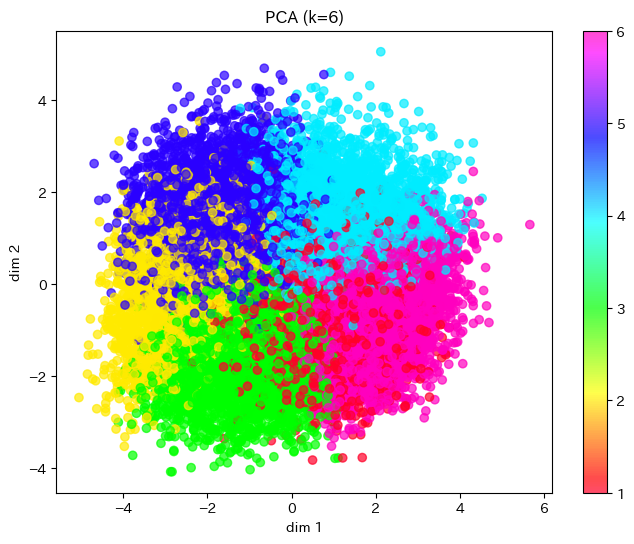

In [61]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca.fit(df_embeddings)
df_embeddings_pca = pca.transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_embeddings_pca[:, 0], df_embeddings_pca[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'PCA (k={k})')
plt.colorbar()
plt.show()

### t-SNE

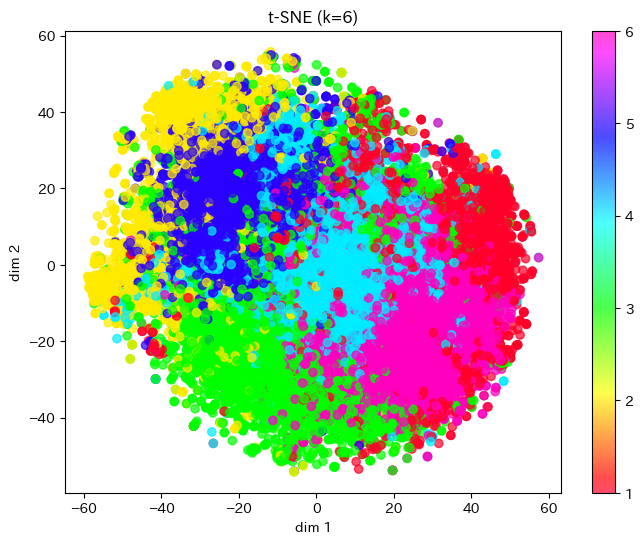

In [62]:


# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={k})')
plt.colorbar()
plt.show()


# in 1min

### UMAP

In [63]:
'''
import umap

# UMAP
umap_obj = umap.UMAP(n_components=2, random_state=0)
df_wrime_features_umap = umap_obj.fit_transform(df_embeddings)

# 可視化
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f'UMAP (k={k})')
plt.colorbar()
plt.show()
'''

"\nimport umap\n\n# UMAP\numap_obj = umap.UMAP(n_components=2, random_state=0)\ndf_wrime_features_umap = umap_obj.fit_transform(df_embeddings)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=clusters, cmap=cmap_name, alpha=0.7)\nplt.xlabel('dim 1')\nplt.ylabel('dim 2')\nplt.title(f'UMAP (k={k})')\nplt.colorbar()\nplt.show()\n"

---

# 感情カテゴリとつぶやき分散表現の関係

---

### 感情カテゴリを正解ラベルとして、つぶやき分散表現から学習

In [64]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_intensity_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_intensity_clusters], ignore_index=True, axis=1)
# df_embeddings_clustersの最後の列を1引く
df_embeddings_clusters.iloc[:, -1] = df_embeddings_clusters.iloc[:, -1] - 1

df_embeddings_clusters

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,-0.187809,-0.029080,-0.679695,-0.096202,-0.572933,0.123853,0.143043,-0.762575,0.458637,...,-0.237778,0.491252,-0.419029,-0.075512,-0.592340,0.193196,-0.133850,0.135610,-0.031740,1
1,train,-0.149567,-0.022400,-0.615797,0.016267,-0.396526,-0.197779,0.109518,-0.546292,0.597835,...,-0.025394,0.147794,-0.278225,0.022705,-0.668020,0.255528,0.133077,0.328987,0.117896,3
2,train,-0.311793,-0.270891,-0.197350,-0.209051,-0.546433,-0.014662,0.223734,-0.550870,0.491359,...,0.278841,0.185260,-0.336378,-0.075834,-0.622448,0.380932,0.119955,0.142896,0.248715,0
3,train,-0.630535,-0.395862,-0.183579,-0.364228,-0.412567,-0.315360,-0.353432,-0.409645,0.250648,...,0.360706,0.126539,0.019109,-0.378566,-0.260030,0.320159,-0.078729,-0.447908,0.303627,2
4,train,0.077433,0.486812,0.400255,-0.118953,-0.420789,0.276861,0.175705,0.012405,0.381621,...,0.290340,0.316523,-0.422998,0.154456,-0.203230,0.572079,-0.196265,-0.114935,0.165855,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,-0.288923,0.319023,-0.429704,-0.029304,-0.243832,0.229808,-0.113894,-0.732758,0.600182,...,0.425314,0.353565,-0.236653,0.096987,-0.999826,0.198945,-0.019930,-0.009789,-0.119333,0
18233,train,-0.327182,-0.221621,-0.274372,-0.190152,-0.431823,-0.151050,0.060120,-0.462811,0.205817,...,0.037315,0.130067,-0.308814,-0.070382,-0.394315,0.068151,0.288643,0.008393,0.222476,2
18234,train,0.102691,-0.025694,-0.271075,0.076021,-0.719141,0.682369,0.045202,-0.750724,0.689253,...,0.030529,0.396864,-0.217960,-0.128605,-0.140058,0.032060,0.099944,-0.035581,-0.036848,0
18235,train,-0.268049,-0.145745,-0.345431,-0.191062,-0.564122,0.209359,0.113148,-0.819570,0.528344,...,-0.101581,0.615846,-0.222008,-0.145953,-0.723587,0.322433,-0.116301,-0.174401,-0.027152,2


In [65]:
# train / test に分割する
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [66]:
import xgboost as xgb

# xgboostの入力データを作成
train_data = df_train.drop([0, 769], axis=1).values
train_labels = df_train[769].values

test_data = df_test.drop([0, 769], axis=1).values
test_labels = df_test[769].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

[0]	train-mlogloss:1.70486	test-mlogloss:1.67977
[1]	train-mlogloss:1.65262	test-mlogloss:1.60188
[2]	train-mlogloss:1.61600	test-mlogloss:1.56181
[3]	train-mlogloss:1.58715	test-mlogloss:1.52879
[4]	train-mlogloss:1.56342	test-mlogloss:1.50113
[5]	train-mlogloss:1.54361	test-mlogloss:1.47711
[6]	train-mlogloss:1.52594	test-mlogloss:1.45389
[7]	train-mlogloss:1.50980	test-mlogloss:1.43844
[8]	train-mlogloss:1.49494	test-mlogloss:1.42644
[9]	train-mlogloss:1.48099	test-mlogloss:1.41029
[10]	train-mlogloss:1.46824	test-mlogloss:1.39779
[11]	train-mlogloss:1.45679	test-mlogloss:1.38651
[12]	train-mlogloss:1.44604	test-mlogloss:1.37515
[13]	train-mlogloss:1.43586	test-mlogloss:1.36151
[14]	train-mlogloss:1.42636	test-mlogloss:1.35401
[15]	train-mlogloss:1.41760	test-mlogloss:1.34684
[16]	train-mlogloss:1.40940	test-mlogloss:1.34040
[17]	train-mlogloss:1.40160	test-mlogloss:1.33385
[18]	train-mlogloss:1.39402	test-mlogloss:1.32607
[19]	train-mlogloss:1.38677	test-mlogloss:1.31925
[20]	train

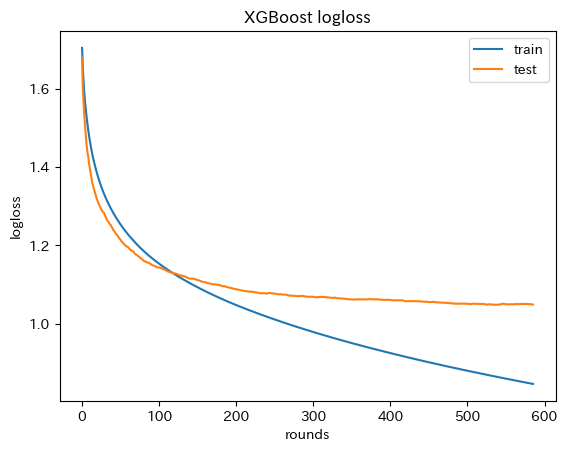

In [67]:
# モデル
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 0.5,
}

history = dict()

# 学習
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=50)

# 予測
preds_labels = model.predict(test_data)

# グラフ描写
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

In [68]:
test_labels += 1
preds_labels += 1

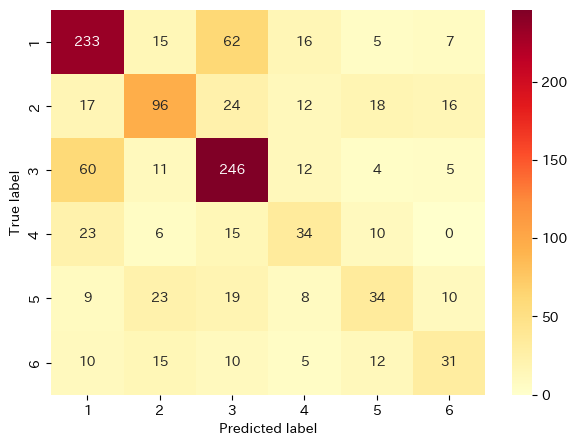

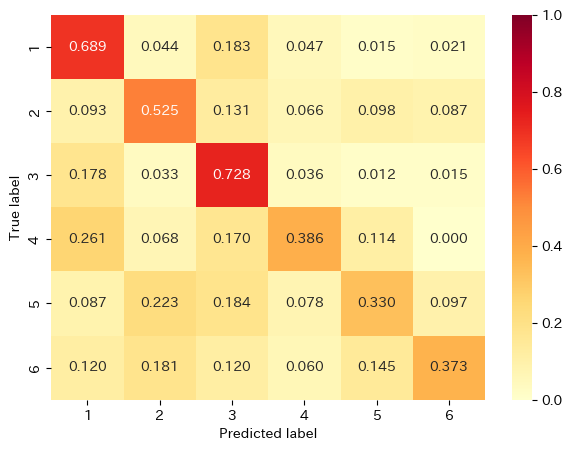

              precision    recall  f1-score   support

           1      0.662     0.689     0.675       338
           2      0.578     0.525     0.550       183
           3      0.654     0.728     0.689       338
           4      0.391     0.386     0.389        88
           5      0.410     0.330     0.366       103
           6      0.449     0.373     0.408        83

    accuracy                          0.595      1133
   macro avg      0.524     0.505     0.513      1133
weighted avg      0.587     0.595     0.589      1133



In [69]:
from sklearn.metrics import classification_report

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

k = 6  
'cl-tohoku/bert-base-japanese-whole-word-masking' は accuracy 60%  
'cl-tohoku/bert-base-japanese-v2' は accuracy 58.6%

In [70]:
# 間違って予測された文章のindexを取得
wrong_preds = np.where(test_labels != preds_labels)[0]

# 間違って予測された文章を5個表示
for i in wrong_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

この性格の悪さを何とかしたい…
True label: 2
Predicted label: 1.0
---
旅に出たい…
True label: 4
Predicted label: 3.0
---
職場でお寿司連れてってもらってお腹パンパン！デザートまで出してもらって大満足。苦しくなるほど食べられるなんて幸せじゃないか。
True label: 3
Predicted label: 2.0
---
友達がハワイで挙式して、森で撮った写真がすごく素敵で羨ましかった。長い髪はゆる巻きダウンにして、お花の冠とベールをつけてるかんじ。木漏れ日を見上げる姿が可愛かったなぁ。
True label: 1
Predicted label: 3.0
---
今日また、ふらりと入れる店が増えた。お酒もご飯も美味しかったし、何より、何となく温かい店だった。
True label: 6
Predicted label: 5.0
---


---